# T-Maze as a prediction problem (comparison with baseline LSTMs)

Optimal actions are picked in the corridor. At T-junction, the learned e-greedy policy is used to pick actions.

Here the only actions available to be learned and picked are the two actions at T-Junctions. So the sequence length remains fixed.

#### All runs have been trucated to 150k episodes. The learning rate is 3e-4 for baselines compared to 3e-5 for the rtnn. It can go even higher for baselines. However for rtnn, we'd end up getting many more failed runs.

No Op actions are used in both cases.

In [1]:
import mariadb
import sys
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os

# JupyterLab renderer support
#jupyter labextension install jupyterlab-plotly@4.14.3

# OPTIONAL: Jupyter widgets extension
#jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.14.3

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
plt.rcParams["figure.figsize"] = (10,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})

#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [3]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run", timestep_col_name="episode", local=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            else:
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [4]:
db = DbAccessor('hshah1_baselines1', local=True)
pd.set_option('display.max_columns', 500)
comment = 'control'
pd.read_sql(f'select * from runs where comment="{comment}"', db.conn)
#pd.read_sql(f'select * from runs inner join run_states on runs.run=run_states.run where comment="{comment}"', db.conn)


,seed,v,w,gpus,name,comment,output_dir,run,INPUT_SIZE,OUTPUT_SIZE,HIDDEN_L_SIZE,STEP_SIZE,TBPTT_T,ADAMB1,ADAMB2,ADAME,LAMBDA,GAMMA,N_TRAIN_STEPS,EPISODES,MAX_EPISODE_LENGTH,EPISODE_GAP,EPSILON,TMAZE_CORRIDOR_LENGTH,PREDICTION_PROBLEM,USE_NO_OPS
0,1.0,0,0,1.0,hshah1_baselines1,control,results/26May2021/hshah1_baselines1/6/5_1/,31.0,3.0,4.0,10.0,0.0003,10.0,0.9,0.999,1.000000e-08,0.0,0.98,2000000.0,250000.0,1000.0,1.0,0.05,2.0,0,1
1,2.0,0,0,1.0,hshah1_baselines1,control,results/26May2021/hshah1_baselines1/6/5_2/,32.0,3.0,4.0,10.0,0.0003,10.0,0.9,0.999,1.000000e-08,0.0,0.98,2000000.0,250000.0,1000.0,1.0,0.05,2.0,0,1
2,3.0,0,0,1.0,hshah1_baselines1,control,results/26May2021/hshah1_baselines1/6/5_4/,33.0,3.0,4.0,10.0,0.0003,10.0,0.9,0.999,1.000000e-08,0.0,0.98,2000000.0,250000.0,1000.0,1.0,0.05,2.0,0,1
3,4.0,0,0,1.0,hshah1_baselines1,control,results/26May2021/hshah1_baselines1/6/5_3/,34.0,3.0,4.0,10.0,0.0003,10.0,0.9,0.999,1.000000e-08,0.0,0.98,2000000.0,250000.0,1000.0,1.0,0.05,2.0,0,1
4,0.0,0,0,1.0,hshah1_baselines1,control,results/26May2021/hshah1_baselines1/7/5_2/,35.0,3.0,4.0,10.0,0.0003,10.0,0.9,0.999,1.000000e-08,0.0,0.98,2000000.0,250000.0,1000.0,1.0,0.05,5.0,0,1
5,1.0,0,0,1.0,hshah1_baselines1,control,results/26May2021/hshah1_baselines1/7/5_1/,36.0,3.0,4.0,10.0,0.0003,10.0,0.9,0.999,1.000000e-08,0.0,0.98,2000000.0,250000.0,1000.0,1.0,0.05,5.0,0,1
6,2.0,0,0,1.0,hshah1_baselines1,control,results/26May2021/hshah1_baselines1/7/5_3/,37.0,3.0,4.0,10.0,0.0003,10.0,0.9,0.999,1.000000e-08,0.0,0.98,2000000.0,250000.0,1000.0,1.0,0.05,5.0,0,1
7,3.0,0,0,1.0,hshah1_baselines1,control,results/26May2021/hshah1_baselines1/7/5_4/,38.0,3.0,4.0,10.0,0.0003,10.0,0.9,0.999,1.000000e-08,0.0,0.98,2000000.0,250000.0,1000.0,1.0,0.05,5.0,0,1
8,4.0,0,0,1.0,hshah1_baselines1,control,results/26May2021/hshah1_baselines1/7/5_5/,39.0,3.0,4.0,10.0,0.0003,10.0,0.9,0.999,1.000000e-08,0.0,0.98,2000000.0,250000.0,1000.0,1.0,0.05,5.0,0,1
9,0.0,0,0,1.0,hshah1_baselines1,control,results/26May2021/hshah1_baselines1/8/5_1/,40.0,3.0,4.0,10.0,0.0003,10.0,0.9,0.999,1.000000e-08,0.0,0.98,2000000.0,250000.0,1000.0,1.0,0.05,10.0,0,1


In [11]:
def plot_runs(tmaze_len, runs):
    plt.title(f'T-Maze len={tmaze_len}')
    plt.xlabel('episode')
    plt.ylabel('accuracy')
    for k in runs:
        plt.plot(db.get_table('episodic_metrics', k[0], 'accuracy'), label=f'{comment}-{k[0]} | seed:{k[1]}')
    plt.legend()
    plt.show()
    plt.title(f'T-Maze len={tmaze_len}')
    plt.xlabel('episode')
    plt.ylabel('trajectory length')
    for k in runs:
        plt.plot(db.get_table('episodic_metrics', k[0], 'timestep'), label=f'{comment}-{k[0]} | seed:{k[1]}')
    plt.legend()
    plt.show()
    plt.title(f'T-Maze len={tmaze_len}')
    plt.xlabel('episode')
    plt.ylabel('Average cummulative reward per episode')
    for k in runs:
        plt.plot(db.get_table('episodic_metrics', k[0], 'avg_reward'), label=f'{comment}-{k[0]} | seed:{k[1]}')
    plt.legend()
    plt.show()

# T-Maze len 2

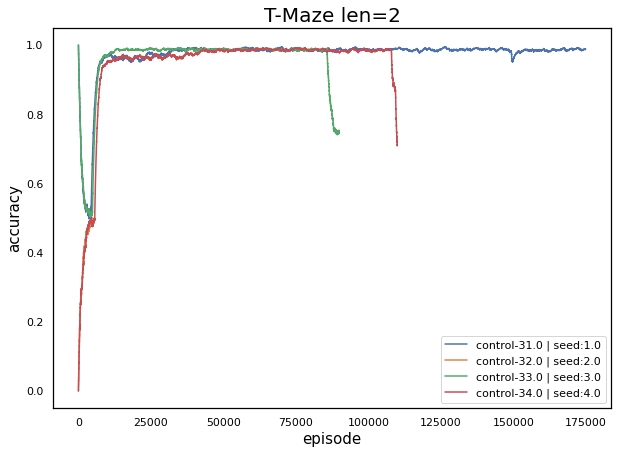

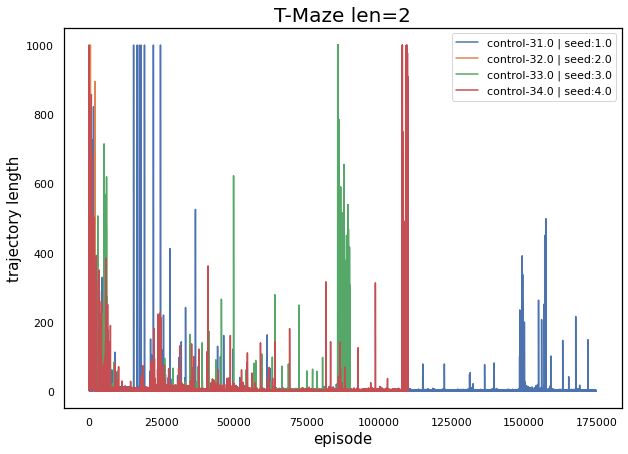

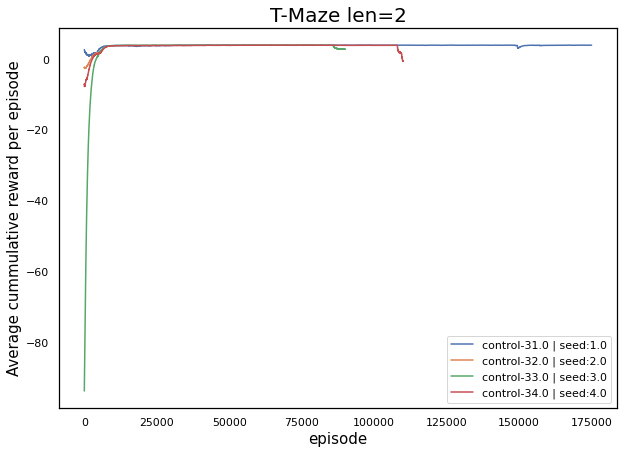

In [14]:
tmaze_len = 2
runs_base = pd.read_sql(f'select run,seed from runs where comment="{comment}" and tmaze_corridor_length={tmaze_len}', db.conn).values
plot_runs(tmaze_len, runs_base)

# T-Maze len 5

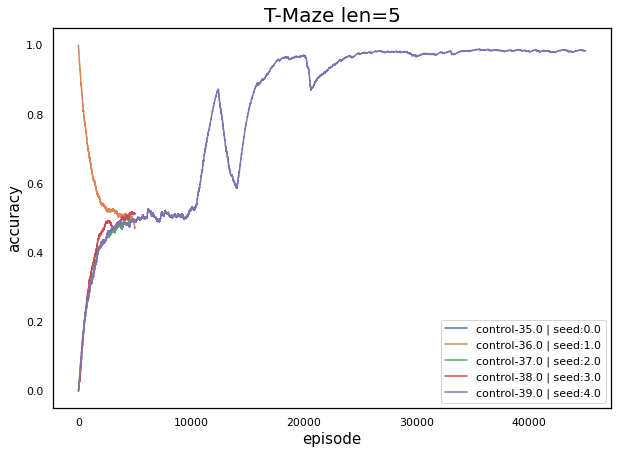

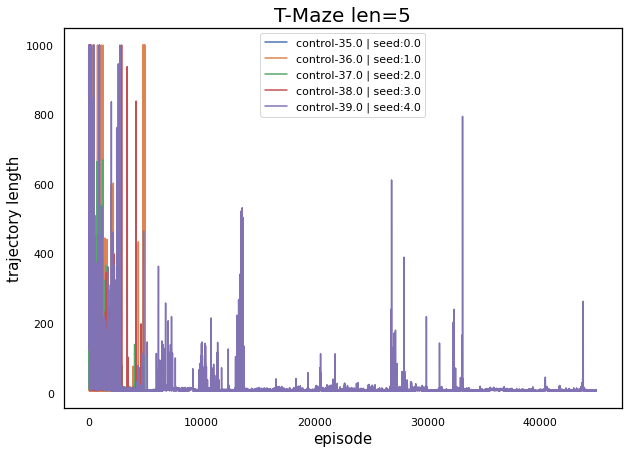

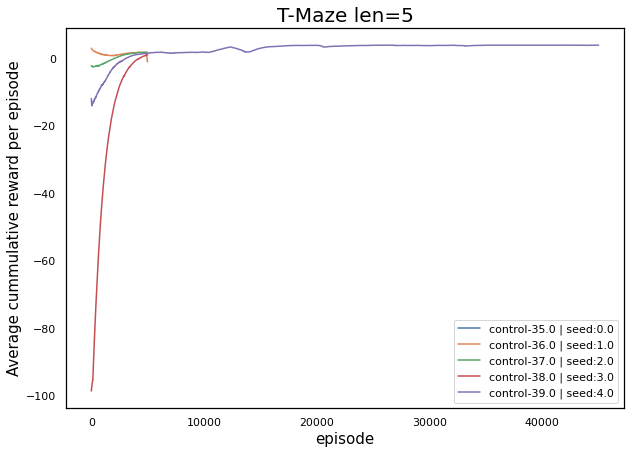

In [15]:
tmaze_len = 5
runs_base = pd.read_sql(f'select run,seed from runs where comment="{comment}" and tmaze_corridor_length={tmaze_len}', db.conn).values
plot_runs(tmaze_len, runs_base)

# T-Maze len 10

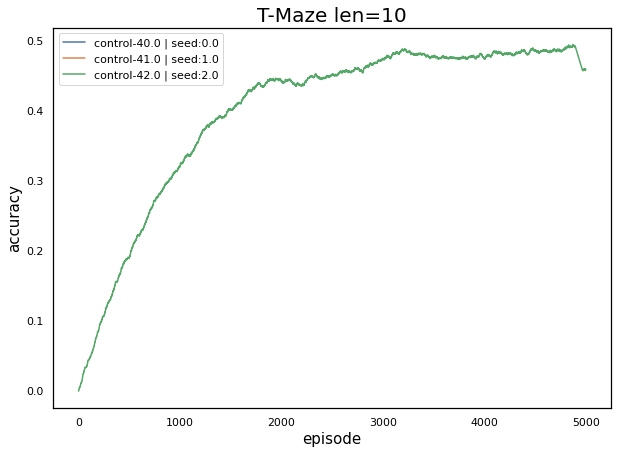

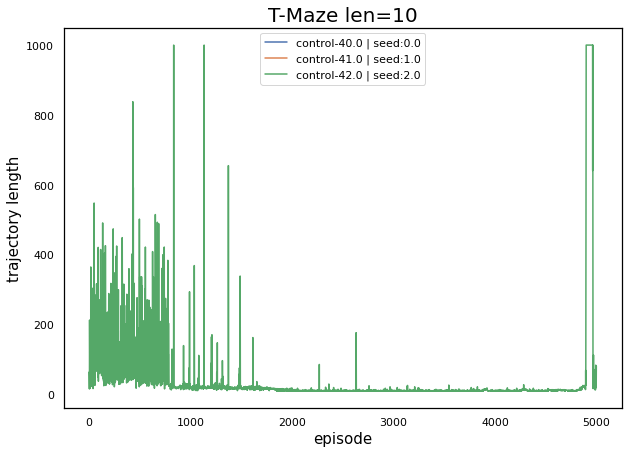

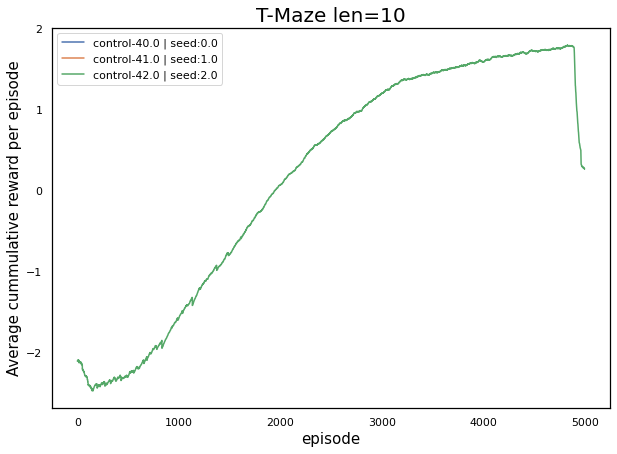

In [16]:
tmaze_len = 10
runs_base = pd.read_sql(f'select run,seed from runs where comment="{comment}" and tmaze_corridor_length={tmaze_len}', db.conn).values
plot_runs(tmaze_len, runs_base)